## Classification with MNIST dataset

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
# Check the environment.
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Data Load

In [3]:
mnist_train = datasets.MNIST(
    root="mnist", 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
) #, target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
mnist_test = datasets.MNIST(
    root="mnist", 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
) #, target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

In [4]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
sample_x, sample_y = mnist_train[0]
print(sample_x.shape)
print(sample_y)

torch.Size([1, 28, 28])
5


In [30]:
# Check the images.
def plot_mnist(data, figsize=(20, 10)):
    fig = plt.figure(figsize=figsize)
    for i in range(18):
        img = data[i][0]
        ax = fig.add_subplot(3, 6, i+1)
        ax.imshow(img.reshape(28, 28), cmap="gray")
        ax.set_title(f"Label: {data[i][1]}")
    pass

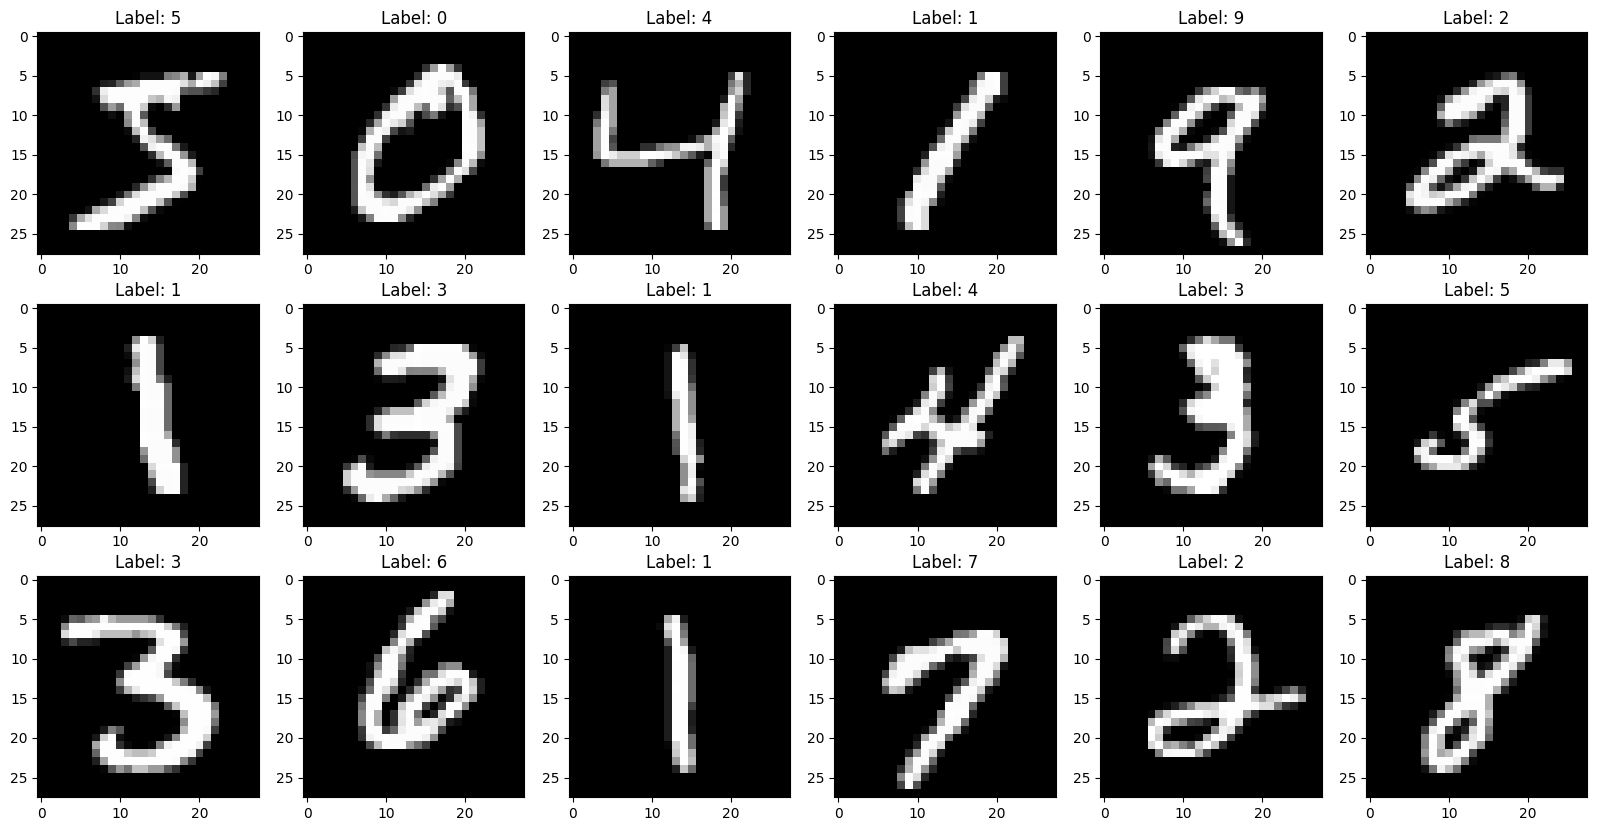

In [31]:
plot_mnist(data=mnist_train)

In [8]:
train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=False, drop_last=True)

### Model

In [9]:
class MNISTClassifier(nn.Module):
    def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )

    def forward(self, x):
    return self.model(x)

In [11]:
# Check the structure of the model.
mlp = MNISTClassifier().to(device)
mlp

MNISTClassifier(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(mlp.parameters(), lr=0.001)

mlp.parameters()

<generator object Module.parameters at 0x0000016A13C1C660>

### Model Training

In [13]:
n_epochs = 20

In [17]:
train_history = {"loss": [], "acc": []}
for e in range(n_epochs):
    print(f"Epoch {e} starts.")
    epoch_loss, epoch_acc = 0, 0
    size = len(train_loader.dataset)
    for b, (x, y) in enumerate(train_loader):
        x.to(device)
        y.to(device)

    pred = mlp(x)
    loss = loss_fn(pred, y)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss = loss.to("cpu").item()
    acc = (pred.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    if b % 200 == 0:
        print(f"loss: {loss:>7f}, acc: {acc:>4f} [{b * len(x)}/{size}]")

    epoch_loss += loss
    epoch_acc += acc

    train_history["loss"].append(epoch_loss / len(train_loader))
    train_history["acc"].append(epoch_acc / len(train_loader))


Epoch 0 starts.
Epoch 1 starts.
Epoch 2 starts.
Epoch 3 starts.
Epoch 4 starts.
Epoch 5 starts.
Epoch 6 starts.
Epoch 7 starts.
Epoch 8 starts.
Epoch 9 starts.
Epoch 10 starts.
Epoch 11 starts.
Epoch 12 starts.
Epoch 13 starts.
Epoch 14 starts.
Epoch 15 starts.
Epoch 16 starts.
Epoch 17 starts.
Epoch 18 starts.
Epoch 19 starts.


In [18]:
print(f"Loss history: {train_history['loss']}")
print(f"Accuracy history: {train_history['acc']}")

Loss history: [0.002455029696257926, 0.0024667938847170315, 0.002470321309222992, 0.0024667427404967547, 0.0024668404488578806, 0.0024533154743076515, 0.002466489054986227, 0.0024571973460715507, 0.002460732149594367, 0.0024601184189510447, 0.0024578553508160083, 0.002457749245642598, 0.0024594120689237385, 0.0024627662137580147, 0.002442209545041861, 0.002457426604491797, 0.002454588736388574, 0.00245935405458432, 0.0024622295811183932, 0.002449404086476329]
Accuracy history: [0.00011672892209178228, 1.667556029882604e-05, 8.33778014941302e-05, 1.667556029882604e-05, 6.670224119530417e-05, 5.002668089647812e-05, 8.33778014941302e-05, 0.00011672892209178228, 5.002668089647812e-05, 6.670224119530417e-05, 6.670224119530417e-05, 0.00011672892209178228, 0.00011672892209178228, 8.33778014941302e-05, 8.33778014941302e-05, 6.670224119530417e-05, 0.00013340448239060833, 6.670224119530417e-05, 1.667556029882604e-05, 0.00013340448239060833]


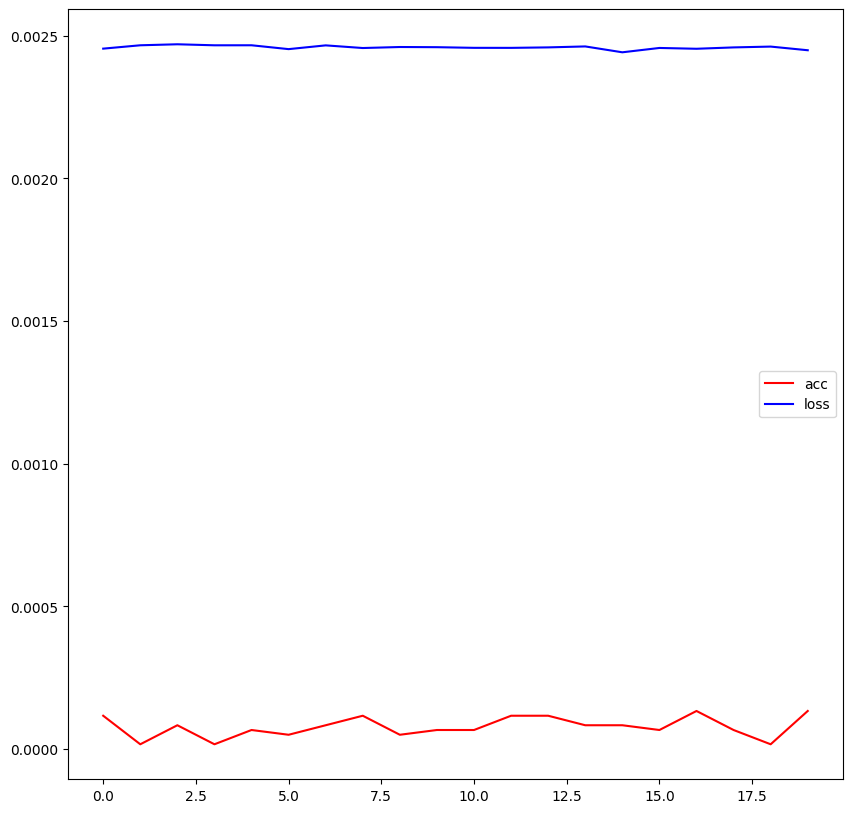

In [24]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_history["acc"], color="red", label="acc")
ax.plot(train_history["loss"], color="blue", label="loss")
ax.legend(loc='right');

### Test

In [20]:
print("Test starts.")
test_loss, test_acc = 0, 0
size = len(test_loader.dataset)

with torch.no_grad():
    for b, (x, y) in enumerate(test_loader):
        x.to(device)
        y.to(device)

        pred = mlp(x)
        test_loss += loss_fn(pred, y).to("cpu").item()
        test_acc += (pred.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"test loss: {test_loss:>7f}, test_acc: {test_acc:>4f}.")

Test starts.
test loss: 2.305215, test_acc: 0.085236.


In [29]:
np.max(train_history['acc']), np.max(train_history['loss'])

(0.00013340448239060833, 0.002470321309222992)

In [ ]:
# test accuracy > train accuracy > Okay!
# If test acc < train acc, "Overfitting".